# RecogNYCe

## Project Description
See [README](./README.md)

## Code

In [121]:
!pip install shapely
!pip install geopandas
!pip install aiohttp
!pip install aiofiles
!pip install opencv-python
#!pip install numpy
#!pip install pandas
#!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for mapillary from https://files.pythonhosted.org/packages/4b/07/c4ccd6677e29ab87bd4cb4ace7b0b3c216596eb9116a6d9f608d262916e3/mapillary-1.0.12-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import shapely
import pandas as pd
import geopandas as gpd
import cv2
from utils.geojson_utils import Neighborhoods

### Location Data Exploration

Loading boroughs
len(nb.neighborhoods) = 5
Plotting boroughs


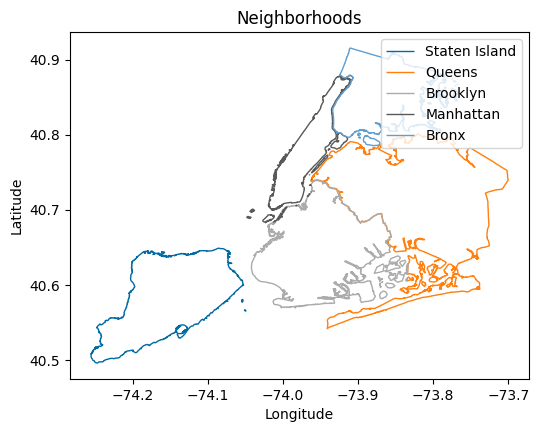

Sampling boroughs
Plotting samples


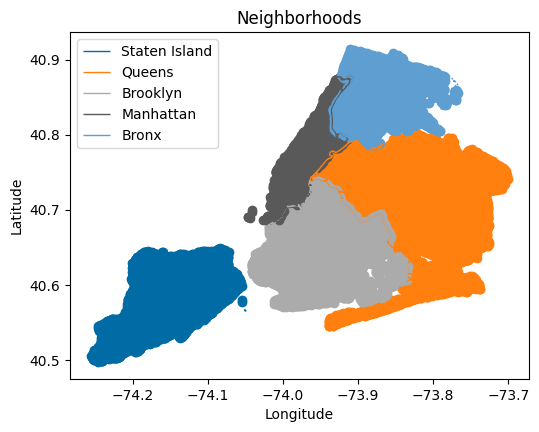

In [3]:
location_dir = "./data/location/"
geo_file = "nyc_boroughs.geojson"
geo_path = os.path.join(location_dir, geo_file)

# Load geojson file
print("Loading boroughs")
nb = Neighborhoods()
nb.load_geojson(geo_path)

print(f"{len(nb.neighborhoods) = }")

# Plot zones
print("Plotting boroughs")
ax = nb.plot()
ax.legend()
plt.show()

# Sample coordinates in neighborhoods
print("Sampling boroughs")
samples = nb.generate_samples(n_points=100000)

# Plot samples
print("Plotting samples")
ax = nb.plot()
ax.legend()
plt.show()

### Scraping street-level image data from coordinates

#### Mapillary

In [6]:
ran = False
from utils.mapillary_utils import download_images_async

In [7]:
assert not ran, "We should really only run this once for each selection of coordinates"

data_dir = "./data/mapillary"
csv_path = os.path.join(data_dir, "data.csv")
append_first = True
radius=50

for i, (neighborhood, coords) in enumerate(zip(nb.neighborhood_names, nb.neighborhood_samples)):
    print(f"Downloading images for {neighborhood} - trying {len(coords)} coordinates")
    results = await download_images_async(coords, neighborhood, data_dir=data_dir, radius=radius, verbose=False)
    append_results = i > 0 or append_first
    results.to_csv(csv_path, index=False, header=not append_results, mode="a" if append_results else "w")
    print(f"Downloaded {len(results)} images")

Downloaded 1087 images
Downloaded 4104 images
Downloaded 2402 images
Downloaded 1829 images
Downloaded 1419 images


In [12]:
# Load dataset
dataset = pd.read_csv(csv_path)
print(f"{len(dataset) = }")
dataset.head(10)

len(dataset) = 22275


,id,longitude,latitude,path,url,borough
0,362372405549249,-74.190323,40.551648,./data/mapillary/Staten Island/362372405549249...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
1,377744433572191,-74.142526,40.639040,./data/mapillary/Staten Island/377744433572191...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
2,586685652304410,-74.179546,40.626955,./data/mapillary/Staten Island/586685652304410...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
3,1872619506230640,-74.117018,40.615104,./data/mapillary/Staten Island/187261950623064...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
4,545737009753366,-74.183586,40.628516,./data/mapillary/Staten Island/545737009753366...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
5,604638233850121,-74.097429,40.574680,./data/mapillary/Staten Island/604638233850121...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
6,4247027342002516,-74.107719,40.619619,./data/mapillary/Staten Island/424702734200251...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
7,818751412382739,-74.157218,40.612331,./data/mapillary/Staten Island/818751412382739...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
8,527717428603442,-74.119584,40.565845,./data/mapillary/Staten Island/527717428603442...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
9,1078417622686437,-74.062989,40.606237,./data/mapillary/Staten Island/107841762268643...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island


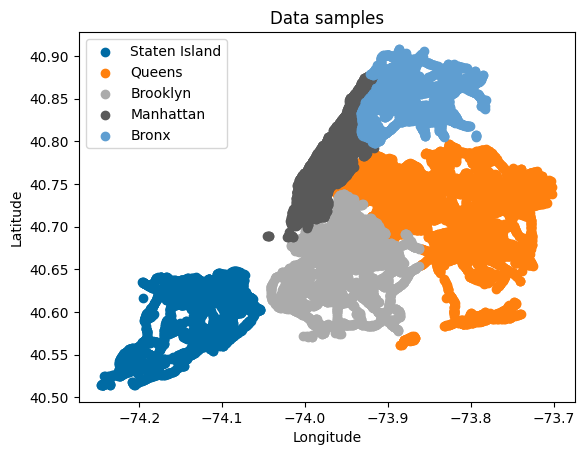

In [9]:
fig, ax = plt.subplots()
boroughs = dataset["borough"].unique()
for i, borough in enumerate(boroughs):
    borough_set = dataset[dataset["borough"] == borough]
    lon = borough_set["longitude"].to_numpy()
    lat = borough_set["latitude"].to_numpy()
    ax.scatter(lon, lat, c=f"C{i}", label=borough)
ax.legend()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Data samples")
plt.show()

#### Google Street View

I am guessing the data will be way higher quality for this.  
It costs money though (see [here](https://developers.google.com/maps/documentation/streetview/usage-and-billing)).  
If we pick 1000 locations per one of the 5 boroughs, it should only be 25$ (and new accounts have 300$ credit so it should be fine).

### Trying a simple classifier

In [3]:
data_dir = "./data/mapillary"
csv_path = os.path.join(data_dir, "data.csv")
dataset = pd.read_csv(csv_path)

In [4]:
print(f"{len(dataset) = }")
dataset.head(10)

len(dataset) = 22275


,id,longitude,latitude,path,url,borough
0,362372405549249,-74.190323,40.551648,./data/mapillary/Staten Island/362372405549249...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
1,377744433572191,-74.142526,40.639040,./data/mapillary/Staten Island/377744433572191...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
2,586685652304410,-74.179546,40.626955,./data/mapillary/Staten Island/586685652304410...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
3,1872619506230640,-74.117018,40.615104,./data/mapillary/Staten Island/187261950623064...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
4,545737009753366,-74.183586,40.628516,./data/mapillary/Staten Island/545737009753366...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
5,604638233850121,-74.097429,40.574680,./data/mapillary/Staten Island/604638233850121...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
6,4247027342002516,-74.107719,40.619619,./data/mapillary/Staten Island/424702734200251...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
7,818751412382739,-74.157218,40.612331,./data/mapillary/Staten Island/818751412382739...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
8,527717428603442,-74.119584,40.565845,./data/mapillary/Staten Island/527717428603442...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
9,1078417622686437,-74.062989,40.606237,./data/mapillary/Staten Island/107841762268643...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island


In [5]:
boroughs = np.sort(dataset["borough"].unique())
label_map = {}
boroughs_map = {}
for i, borough in enumerate(boroughs):
    label_map[borough] = i

In [6]:
def borough_to_label(borough):
    return label_map[borough]

dataset["label"] = dataset["borough"].apply(borough_to_label)

In [7]:
dataset.head(10)

,id,longitude,latitude,path,url,borough,label
0,362372405549249,-74.190323,40.551648,./data/mapillary/Staten Island/362372405549249...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4
1,377744433572191,-74.142526,40.639040,./data/mapillary/Staten Island/377744433572191...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4
2,586685652304410,-74.179546,40.626955,./data/mapillary/Staten Island/586685652304410...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4
3,1872619506230640,-74.117018,40.615104,./data/mapillary/Staten Island/187261950623064...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4
4,545737009753366,-74.183586,40.628516,./data/mapillary/Staten Island/545737009753366...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4
5,604638233850121,-74.097429,40.574680,./data/mapillary/Staten Island/604638233850121...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4
6,4247027342002516,-74.107719,40.619619,./data/mapillary/Staten Island/424702734200251...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4
7,818751412382739,-74.157218,40.612331,./data/mapillary/Staten Island/818751412382739...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4
8,527717428603442,-74.119584,40.565845,./data/mapillary/Staten Island/527717428603442...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4
9,1078417622686437,-74.062989,40.606237,./data/mapillary/Staten Island/107841762268643...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,4


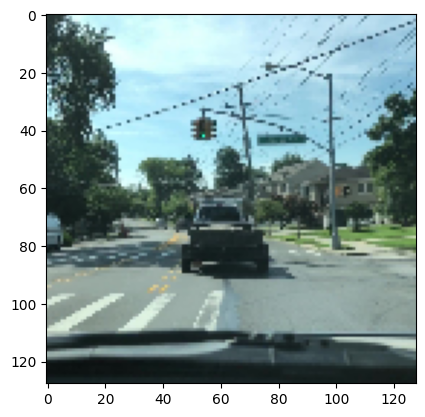

In [8]:
img_paths = dataset["path"]
labels = dataset["label"]

def load_img(path, crop=True, resolution=128):
    img = cv2.imread(path)
    h, w, c = img.shape
    d_min = min(h, w)
    img_cropped = img[(h-d_min)//2:(h+d_min)//2, (w-d_min)//2:(w+d_min)//2, :]
    img_scaled = cv2.resize(img_cropped, (resolution, resolution), interpolation= cv2.INTER_LINEAR)
    return img_scaled

def plot_img(img):
    fig, ax = plt.subplots()
    ax.imshow(img[:,:,::-1])
    return fig, ax

img = load_img(img_paths[0])
fig, ax = plot_img(img)
plt.show()

In [9]:
# Permute & select random subset
n_samples = 1000
indices = np.random.permutation(len(labels))
labels_s = labels[indices][:n_samples]
img_paths_s = img_paths[indices][:n_samples]
imgs_s = [load_img(path) for path in img_paths_s]

In [2]:
import tensorflow as tf
import tensorflow.keras as krs

2023-11-02 20:36:05.271884: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 20:36:05.309699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 20:36:05.309734: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 20:36:05.309762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 20:36:05.316705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 20:36:05.317540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [10]:
def create_model(n_classes = 5):
    n_filters_1 = 16
    filter_size_1 = 4

    n_filters_2 = 32
    filter_size_2 = 4

    n_filters_3 = 64
    filter_size_3 = 4

    reg_conv = 1e-5

    n_dense_1 = 128
    n_dense_2 = 64

    reg_dense = 1e-4

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                n_filters_1,
                filter_size_1,
                padding="same",
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.L2(reg_conv),
                bias_regularizer=tf.keras.regularizers.L2(reg_conv),
            ), # (28, 28, n_filters_1)
            tf.keras.layers.MaxPooling2D(
                pool_size=(2, 2),
            ), # (14, 14, n_filters_2)
            tf.keras.layers.Conv2D(
                n_filters_2,
                filter_size_2,
                padding="same",
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.L2(reg_conv),
                bias_regularizer=tf.keras.regularizers.L2(reg_conv),
            ), # (14, 14, n_filters_2)
            tf.keras.layers.MaxPooling2D(
                pool_size=(2, 2),
            ), # (7, 7, n_filters_2)
            tf.keras.layers.Conv2D(
                n_filters_3,
                filter_size_3,
                padding="same",
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.L2(reg_conv),
                bias_regularizer=tf.keras.regularizers.L2(reg_conv),
            ), # (14, 14, n_filters_3)
            tf.keras.layers.MaxPooling2D(
                pool_size=(2, 2),
            ), # (3, 3, n_filters_3)
            tf.keras.layers.Flatten(), # 3 * 3 * n_filters_3
            tf.keras.layers.Dense(
                n_dense_1,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.L2(reg_dense),
                bias_regularizer=tf.keras.regularizers.L2(reg_dense),
            ), # n_dense_1
            tf.keras.layers.Dense(
                n_dense_2,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.L2(reg_dense),
                bias_regularizer=tf.keras.regularizers.L2(reg_dense),
            ), # n_dense_2
            tf.keras.layers.Dense(
                n_classes,
                activation="sigmoid",
                kernel_regularizer=tf.keras.regularizers.L2(reg_dense),
                bias_regularizer=tf.keras.regularizers.L2(reg_dense),
            ), # n_classes
        ]
    )
    return model

In [19]:
X = np.array(imgs_s) / 255
y = np.array(labels_s)

val_frac = 0.2
n_val = int(len(X) * val_frac)
X_train = X[:-n_val]
y_train = y[:-n_val]
X_val = X[-n_val:]
y_val = y[-n_val:]

print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_val.shape = }")
print(f"{y_val.shape = }")

X_train.shape = (800, 128, 128, 3)
y_train.shape = (800,)
X_val.shape = (200, 128, 128, 3)
y_val.shape = (200,)


In [20]:
model = create_model()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/10


2023-11-02 20:42:00.730023: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157286400 exceeds 10% of free system memory.


32/32 [==============================] - 8s 223ms/step - loss: 1.6029 - accuracy: 0.3450 - val_loss: 1.5996 - val_accuracy: 0.3000
Epoch 2/10
32/32 [==============================] - 7s 215ms/step - loss: 1.5240 - accuracy: 0.3713 - val_loss: 1.5404 - val_accuracy: 0.3000
Epoch 3/10
32/32 [==============================] - 7s 218ms/step - loss: 1.5182 - accuracy: 0.3713 - val_loss: 1.5320 - val_accuracy: 0.3000
Epoch 4/10
32/32 [==============================] - 7s 215ms/step - loss: 1.5135 - accuracy: 0.3713 - val_loss: 1.5169 - val_accuracy: 0.3000
Epoch 5/10
32/32 [==============================] - 7s 216ms/step - loss: 1.4815 - accuracy: 0.3738 - val_loss: 1.5232 - val_accuracy: 0.3600
Epoch 6/10
32/32 [==============================] - 7s 218ms/step - loss: 1.4699 - accuracy: 0.3537 - val_loss: 1.4752 - val_accuracy: 0.3050
Epoch 7/10
32/32 [==============================] - 7s 217ms/step - loss: 1.4204 - accuracy: 0.3925 - val_loss: 1.4203 - val_accuracy: 0.4150
Epoch 8/10
32/32 

In [21]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=25,
    epochs=10,
    validation_data=(X_val, y_val),
)

Epoch 1/10


2023-11-02 20:43:19.605230: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157286400 exceeds 10% of free system memory.


32/32 [==============================] - 7s 220ms/step - loss: 1.0870 - accuracy: 0.5763 - val_loss: 1.4972 - val_accuracy: 0.4200
Epoch 2/10
32/32 [==============================] - 7s 215ms/step - loss: 0.9490 - accuracy: 0.6200 - val_loss: 1.5610 - val_accuracy: 0.4400
Epoch 3/10
32/32 [==============================] - 7s 215ms/step - loss: 0.7863 - accuracy: 0.7188 - val_loss: 1.6822 - val_accuracy: 0.4150
Epoch 4/10
32/32 [==============================] - 7s 214ms/step - loss: 0.6075 - accuracy: 0.7900 - val_loss: 2.0034 - val_accuracy: 0.4700
Epoch 5/10
32/32 [==============================] - 7s 211ms/step - loss: 0.4072 - accuracy: 0.8725 - val_loss: 2.1853 - val_accuracy: 0.4000
Epoch 6/10
32/32 [==============================] - 7s 212ms/step - loss: 0.2783 - accuracy: 0.9212 - val_loss: 2.4339 - val_accuracy: 0.4600
Epoch 7/10
32/32 [==============================] - 7s 210ms/step - loss: 0.1826 - accuracy: 0.9550 - val_loss: 2.7837 - val_accuracy: 0.4500
Epoch 8/10
32/32 

In [24]:
y_val_hat = np.argmax(np.array(model(X_val)), axis=1)

In [26]:
y_labels = [boroughs[i] for i in y_val]
y_labels_hat = [boroughs[i] for i in y_val_hat]

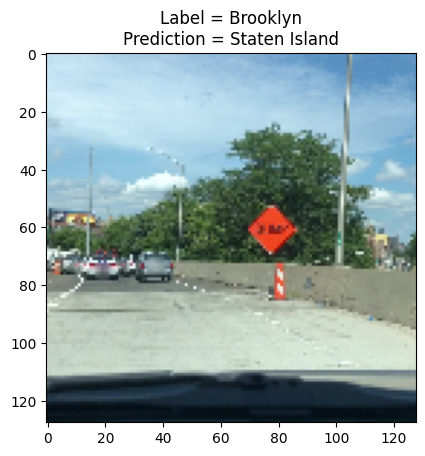

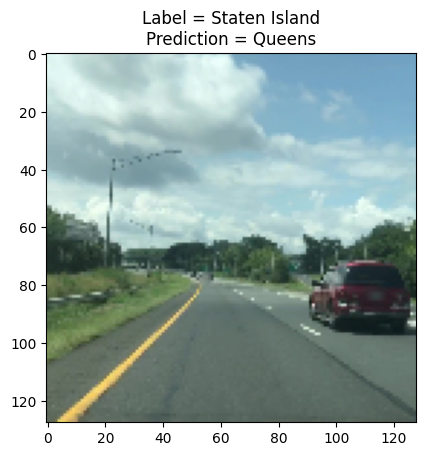

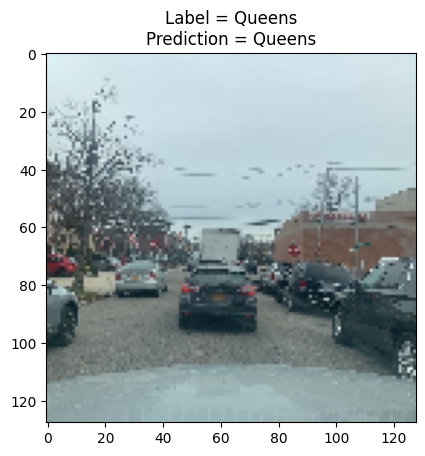

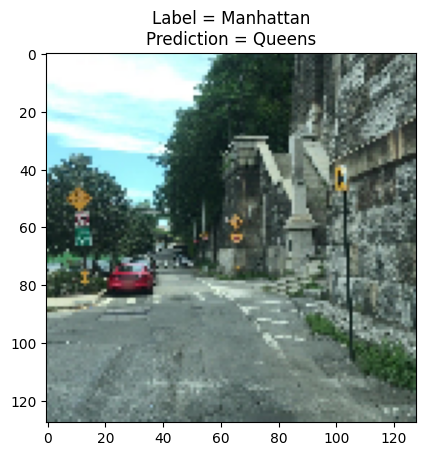

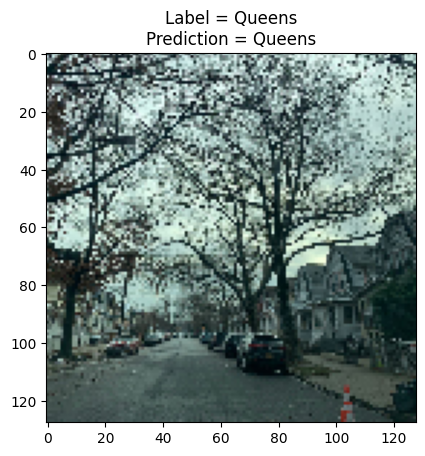

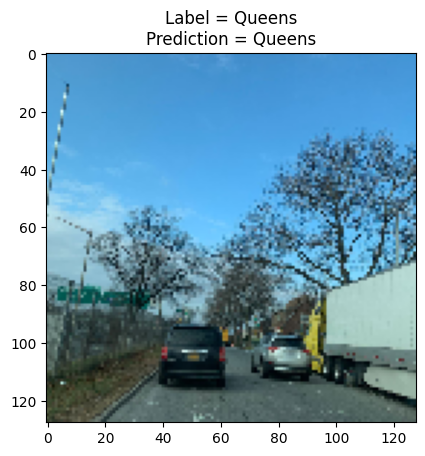

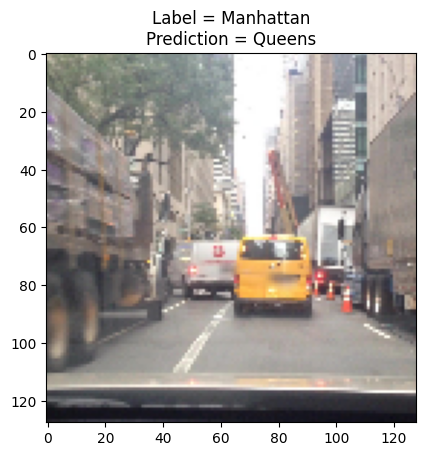

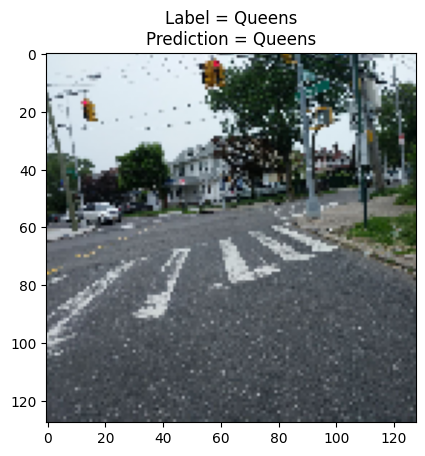

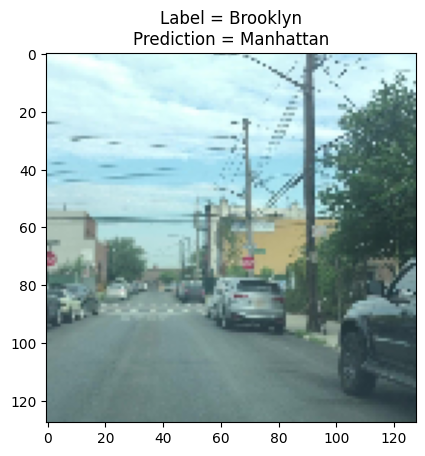

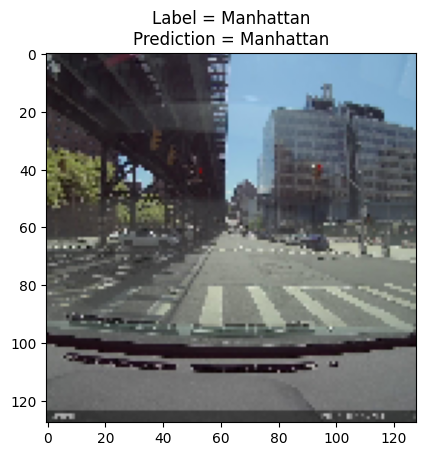

In [32]:
for n in range(10):
    i = np.random.choice(len(y_labels))
    label = y_labels[i]
    label_hat = y_labels_hat[i]
    img = X_val[i]

    fig, ax = plot_img(img)
    ax.set_title(f"Label = {label}\nPrediction = {label_hat}")
